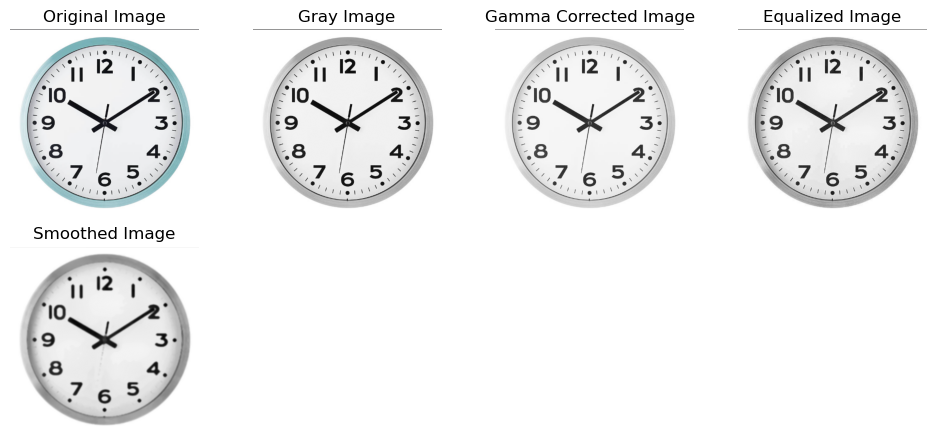

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return None
    return image

def gamma_correction(image, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(image, table)

# def Manual_equalizeHist(image):
#     M,N = image.shape
#     total_pixels = M * N
#     L = 256
#     histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    
#     probability = np.zeros(L, dtype=np.float32)
#     for i in range(L):
#         probability[i] = histogram[i] / total_pixels
        
#     cum_sum_array = np.zeros(L, dtype=np.float32)
#     trans_func = np.zeros(L, dtype=np.float32)
#     for i in range(L):
#         cum_sum = 0.0
#         for j in range(i+1):
#             cum_sum += probability[j]
#         cum_sum_array[i] = cum_sum
#         trans_func[i] = (L-1) * cum_sum_array[i]
#         if trans_func[i] > 255:
#             trans_func[i] = 255
            
#     equalized_img = cv2.LUT(image, trans_func.astype(np.uint8))
#     return histogram, probability, cum_sum_array, trans_func, equalized_img

def clahe_equalize(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab_eq = cv2.merge((cl, a, b))
    equalized_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    gray_eq = cv2.cvtColor(equalized_img, cv2.COLOR_BGR2GRAY)
    return gray_eq

def plot_histogram(img, title, pos):
    plt.subplot(2, 3, pos)
    plt.hist(img.ravel(), bins=256, range=[0, 256], color='black')
    plt.title(title)
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    
def smoothing(image):
    smoothed = cv2.medianBlur(image, 5) 
    smoothed = cv2.bilateralFilter(smoothed, 100, 2, 2)
    smoothed = cv2.GaussianBlur(smoothed, (5,5), 0)
    return smoothed

image_path = 'input images/input3.png'
image = load_image(image_path)
if image is None:
    exit()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gamma = 1.5
gamma_corrected = gamma_correction(gray, gamma)
gamma_corrected_bgr = cv2.cvtColor(gamma_corrected, cv2.COLOR_GRAY2BGR)

# hist, prob, cdf, trans, eq_img = Manual_equalizeHist(gray)

equalized_img = clahe_equalize(gamma_corrected_bgr)

smoothed = smoothing(equalized_img)

plt.figure(figsize=(12, 8))
plt.subplot(3, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(gray, cmap='gray')
plt.title('Gray Image')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(gamma_corrected_bgr, cmap='gray')
plt.title('Gamma Corrected Image')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(equalized_img, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

# plot_histogram(gray, 'Original Histogram', 5)
# plot_histogram(equalized_img, 'Equalized Histogram', 6)

plt.subplot(3, 4, 5)
plt.imshow(smoothed, cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')

# plt.tight_layout()
plt.show()
